In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Dec 22 11:30:30 2017

@author: thomas
"""

from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import openFOAM_FINAL as foam
import os
import sys
sys.path.append("..")
from sklearn.ensemble import RandomForestRegressor

import sys
sys.path.append("..")

home = os.path.realpath('MinorCSE') + '/'

##################################################################################################################
######################################### Loading the RANS data ##################################################
##################################################################################################################
def RANS(case, Re, TurbModel, time_end, nx, ny):
    dir_RANS  = home + ('%s' % case) + '/' + ('Re%i_%s' % (Re,TurbModel))
    if case == 'SquareDuct':
        dir_RANS = dir_RANS + '_50'
        if Re > 2000:
            time_end = 50000
            
    if case == 'ConvergingDivergingChannel':
        dir_RANS = dir_RANS + '_100'
        
    mesh_list  = foam.getRANSVector(dir_RANS, time_end, 'cellCentres')
    mesh      = foam.getRANSPlane(mesh_list,'2D', nx, ny, 'vector')
    #velocity
    U_list    = foam.getRANSVector(dir_RANS, time_end, 'U')
    U        = foam.getRANSPlane(U_list,'2D', nx, ny, 'vector')
    #velocity gradient
    gradU_list  = foam.getRANSTensor(dir_RANS, time_end, 'grad(U)')
    gradU      = foam.getRANSPlane(gradU_list,'2D', nx, ny, 'tensor')
    #pressure
    p_list    = foam.getRANSScalar(dir_RANS, time_end, 'p')
    p        = foam.getRANSPlane(p_list,'2D', nx, ny, 'scalar')
    #pressure gradient
    gradp_list    = foam.getRANSVector(dir_RANS, time_end, 'grad(p)')
    gradp        = foam.getRANSPlane(gradp_list,'2D', nx, ny, 'vector')
    #Reynolds stress tensor
    tau_list  = foam.getRANSSymmTensor(dir_RANS, time_end, 'R')
    tau      = foam.getRANSPlane(tau_list,'2D', nx, ny, 'tensor')
    #k
    k_list    = foam.getRANSScalar(dir_RANS, time_end, 'k')
    k        = foam.getRANSPlane(k_list,'2D', nx, ny, 'scalar')
    #k gradient
    gradk_list    = foam.getRANSVector(dir_RANS, time_end, 'grad(k)')
    gradk        = foam.getRANSPlane(gradk_list,'2D', nx, ny, 'vector')
    #distance to wall
    yWall_list = foam.getRANSScalar(dir_RANS, time_end, 'yWall')
    yWall        = foam.getRANSPlane(yWall_list,'2D', nx, ny, 'scalar')
    #omega
    omega_list  = foam.getRANSScalar(dir_RANS, time_end, 'omega')
    omega      = foam.getRANSPlane(omega_list, '2D', nx, ny, 'scalar')
    #S R tensor
    S, Omega  = foam.getSRTensors(gradU)
    
    return mesh, U, gradU, p, gradp, tau, k, gradk, yWall, omega, S, Omega

##################################################################################################################
######################################### Features  ##############################################################
##################################################################################################################
def q1(S, Omega): 
    a = np.shape(S)
    q1 = np.zeros((a[2],a[3]))
    for i1 in range(a[2]):
        for i2 in range(a[3]):               
            raw = 0.5*(np.abs(np.trace(np.dot(S[:,:,i1,i2],S[:,:,i1,i2]))) - np.abs(np.trace(np.dot(Omega[:,:,i1,i2],-1*(Omega[:,:,i1,i2])))))
            norm = np.trace(np.dot(S[:,:,i1,i2],S[:,:,i1,i2]))
            q1[i1,i2] = raw/(np.abs(raw) + np.abs(norm))
    return q1

def q2(k, U):
    a = np.shape(k)
    q2 = np.zeros((a[1],a[2]))
    for i1 in range(a[1]):
        for i2 in range(a[2]):               
            raw = k[0,i1,i2]
            norm = 0.5*(np.inner(U[:, i1, i2], U[:, i1, i2])) # inner is equivalent to sum UiUi
            q2[i1,i2] = raw/(np.abs(raw) + np.abs(norm))
    return q2

    
def q3(k, yWall, nu=1.4285714285714286e-03):
    a = np.shape(k)
    q3 = np.zeros((a[1],a[2]))
    for i1 in range(a[1]):
        for i2 in range(a[2]):               
            q3[i1,i2] = np.minimum((np.sqrt(k[:,i1,i2][0])*yWall[:, i1, i2])/(50*nu), 2)
    return q3
    

def q4(U, gradP):
    a = np.shape(gradP)
    q4 = np.zeros((a[1],a[2]))
    for i1 in range(a[1]):
        for i2 in range(a[2]):
            raw  = np.einsum('k,k', U[:,i1,i2], gradP[:,i1,i2])
            norm = np.einsum('j,j,i,i', gradP[:,i1,i2], gradP[:,i1,i2], U[:, i1, i2],U[:, i1, i2])
            
            q4[i1,i2] = raw / (np.fabs(norm) + np.fabs(raw));
    return q4


def q5(k, S, omega, Cmu=0.09):
    a = np.shape(k)
    q5 = np.zeros((a[1],a[2]))
    for i1 in range(a[1]):
        for i2 in range(a[2]):    
            epsilon = Cmu * k[:, i1, i2] * omega[:,i1,i2]
            raw = k[:,i1,i2] / epsilon
            norm = 1 / np.sqrt(np.trace(np.dot(S[:,:,i1,i2], S[:,:,i1,i2])))
            q5[i1,i2] = raw/(np.fabs(raw) + np.fabs(norm))
    return q5


def q6(gradP, gradU, p, U):
    a = np.shape(gradP)
    q6 = np.zeros((a[1],a[2]))
    for i1 in range(a[1]):
        for i2 in range(a[2]):
            raw  = np.sqrt(np.einsum('i,i', gradP[:,i1,i2], gradP[:,i1,i2]))
            norm = np.einsum('k, kk', U[:,i1,i2], gradU[:,:,i1,i2])
           
            norm *= 0.5 * p[0,i1,i2]
            q6[i1,i2] = raw/(np.fabs(raw) + np.fabs(norm))
    return q6
    

def q7(U, gradU):
    a = np.shape(U)
    q7 = np.zeros((a[1],a[2]))
    for i1 in range(a[1]):
        for i2 in range(a[2]):    
            raw = np.fabs(np.einsum('i, j, ij', U[:,i1,i2], U[:,i1,i2], gradU[:,:,i1,i2]))
            norm = np.sqrt(np.einsum('l, l, i, ij, k, kj', U[:,i1,i2], U[:,i1,i2], U[:,i1,i2], gradU[:,:,i1,i2], U[:,i1,i2], gradU[:,:,i1,i2]))
            q7[i1,i2] = raw/(np.fabs(raw) + np.fabs(norm))
    return q7



def q8(U, gradK, Tau, S):
    a = np.shape(U)
    q8 = np.zeros((a[1],a[2]))
    for i1 in range(a[1]):
        for i2 in range(a[2]):
            raw  = np.einsum('i,i', U[:,i1,i2], gradK[:,i1,i2])
            norm = np.einsum('jk,jk', Tau[:,:,i1,i2], S[:,:,i1,i2])
            q8[i1,i2] = raw/(np.fabs(raw) + np.fabs(norm))              
    return q8
  

def q9(tau, k):
    a = np.shape(k)
    q9 = np.zeros((a[1],a[2]))
    for i1 in range(a[1]):
        for i2 in range(a[2]):    
            raw = np.sqrt(np.trace(np.dot(tau[:,:,i1,i2], np.transpose(tau[:,:,i1,i2]))))
            norm = k[:,i1,i2]
            q9[i1,i2] = raw/(np.fabs(raw) + np.fabs(norm))
    return q9   

##################################################################################################################
######################################### Feature function #######################################################
##################################################################################################################
    
def features(case, Re, TurbModel, time_end, nx, ny):
    X = np.zeros((nx*len(Re) * ny, 9))
    
    for i in range(len(Re)):
        meshRANS, U_RANS, gradU_RANS, p_RANS, gradp_RANS, tau_RANS, k_RANS, gradk_RANS, yWall_RANS, omega_RANS, S_RANS, Omega_RANS = RANS(case, Re[i], TurbModel, time_end, nx, ny)
        feature = np.zeros((9, nx, ny))
        feature[0,:,:] = q1(S_RANS, Omega_RANS)
        feature[1,:,:] = q2(k_RANS, U_RANS)
        feature[2,:,:] = q3(k_RANS, yWall_RANS)
        feature[3,:,:] = q4(U_RANS, gradp_RANS)
        feature[4,:,:] = q5(k_RANS, S_RANS, omega_RANS)
        feature[5,:,:] = q6(gradp_RANS, gradU_RANS, p_RANS,U_RANS)
        feature[6,:,:] = q7(U_RANS, gradU_RANS)
        feature[7,:,:] = q8(U_RANS, gradk_RANS, tau_RANS, S_RANS)
        feature[8,:,:] = q9(tau_RANS, k_RANS)
        feature = np.reshape(feature.swapaxes(1,2), (nx*ny, 9), "F")
        feature = np.reshape(feature.swapaxes(1,0), (nx*ny, 9))
        X[i*nx*ny:(i+1)*nx*ny, :] = feature
    return X

##################################################################################################################
##################################### Eigenvalue discripancy function ############################################
##################################################################################################################

def response(case, Re, TurbModel, time_end, nx, ny, train): 
    if train ==True:
        print('train = true')
        Y = np.zeros((nx*len(Re)*ny, 6))
        for i in range(len(Re)):
            if case == 'PeriodicHills':
                dataset = home + ('%s' % (case)) + '/' + ('DATA_CASE_LES_BREUER') + '/' + ('Re_%i' % Re[i]) + '/' + ('Hill_Re_%i_Breuer.csv' % Re[i])
            if case == 'SquareDuct':
                dataset = ('MinorCSE/SquareDuct/DATA/0%i_full.csv' % Re[i])
           
                
            meshRANS, U_RANS, gradU_RANS, p_RANS, gradp_RANS, tau_RANS, k_RANS, gradk_RANS, yWall_RANS, omega_RANS, S_RANS, Omega_RANS = RANS(case, Re[i], TurbModel, time_end, nx, ny)

            dataDNS = foam.loadData_avg(case, dataset)
            dataDNS_i = foam.interpDNSOnRANS(case, dataDNS, meshRANS)
       
            dataDNS_i['k'] = 0.5 * (dataDNS_i['uu'] + dataDNS_i['vv'] + dataDNS_i['ww'])

            l1 = np.shape(U_RANS)[1]
            l2 = np.shape(U_RANS)[2]

            ReStress_DNS = np.zeros([3,3,l1,l2])
            ReStress_DNS[0,0,:,:] = dataDNS_i['uu']
            ReStress_DNS[1,1,:,:] = dataDNS_i['vv']
            ReStress_DNS[2,2,:,:] = dataDNS_i['ww']
            ReStress_DNS[0,1,:,:] = dataDNS_i['uv']
            ReStress_DNS[1,0,:,:] = dataDNS_i['uv']

            aij_DNS = np.zeros([3,3,l1,l2])
            dataRANS_k = np.zeros([l1,l2])
            dataRANS_aij = np.zeros([3,3,l1,l2])

            for j in range(l1):
                for k in range(l2):
                    aij_DNS[:,:,j,k] = ReStress_DNS[:,:,j,k]/(2.*dataDNS_i['k'][j,k]) - np.diag([1/3.,1/3.,1/3.])
                    dataRANS_k[j,k] = 0.5 * np.trace(tau_RANS[:,:,j,k])
                    dataRANS_aij[:,:,j,k] = tau_RANS[:,:,j,k]/(2.*dataRANS_k[j,k]) - np.diag([1/3.,1/3.,1/3.])

            aneigVal_DNS = foam.calcEigenvalues(ReStress_DNS, dataDNS_i['k'])
            baryMap_DNS = foam.barycentricMap(aneigVal_DNS)

            aneigVal_RANS = foam.calcEigenvalues(tau_RANS, dataRANS_k)
            baryMap_RANS = foam.barycentricMap(aneigVal_RANS)

            
            eigVal_RANS, eigVec_RANS = foam.eigenDecomposition(dataRANS_aij)
            eigVal_DNS, eigVec_DNS = foam.eigenDecomposition(aij_DNS)
            
            phi_RANS =  np.reshape(( np.reshape((foam.eigenvectorToEuler(eigVec_RANS)).swapaxes(1,2), (nx*ny, 3), "F")).swapaxes(1,0), (nx*ny, 3))
            phi_DNS =  np.reshape(( np.reshape((foam.eigenvectorToEuler(eigVec_DNS)).swapaxes(1,2), (nx*ny, 3), "F")).swapaxes(1,0), (nx*ny, 3))
            
            baryMap_discr = np.reshape(( np.reshape((foam.baryMap_discr(baryMap_RANS, baryMap_DNS)).swapaxes(1,2), (nx*ny, 2), "F")).swapaxes(1,0), (nx*ny, 2))

            phi_discr = phi_DNS - phi_RANS
            k_discr = np.reshape(( np.reshape((dataDNS_i['k'] - k_RANS).swapaxes(1,2), (nx*ny, 1), "F")).swapaxes(1,0), (nx*ny, 1))
        
            Y[i*nx*ny:(i+1)*nx*ny, 0:2] = baryMap_discr
            Y[i*nx*ny:(i+1)*nx*ny, 2:5] = phi_discr
            Y[i*nx*ny:(i+1)*nx*ny, 5] = k_discr[:,0]
            

        print('return Y')
        return Y
    
    else:
        print('train = false')
        for i in range(len(Re)):
            if case == 'PeriodicHills':
                dataset = home + ('%s' % (case)) + '/' + ('DATA_CASE_LES_BREUER') + '/' + ('Re_%i' % Re[i]) + '/' + ('Hill_Re_%i_Breuer.csv' % Re[i])
            if case == 'SquareDuct':
                dataset = ('MinorCSE/SquareDuct/DATA/0%i_full.csv' % Re[i])
            if case == 'ConvergingDivergingChannel':
                dataset = ('MinorCSE/ConvergingDivergingChannel/DATA/conv-div-mean-half.dat')
                
            meshRANS, U_RANS, gradU_RANS, p_RANS, gradp_RANS, tau_RANS, k_RANS, gradk_RANS, yWall_RANS, omega_RANS, S_RANS, Omega_RANS = RANS(case, Re[i], TurbModel, time_end, nx, ny)

            dataDNS = foam.loadData_avg(case, dataset)
            dataDNS_i = foam.interpDNSOnRANS(case, dataDNS, meshRANS)
            dataDNS_i['k'] = 0.5 * (dataDNS_i['uu'] + dataDNS_i['vv'] + dataDNS_i['ww'])

            l1 = np.shape(U_RANS)[1]
            l2 = np.shape(U_RANS)[2]

            ReStress_DNS = np.zeros([3,3,l1,l2])
            ReStress_DNS[0,0,:,:] = dataDNS_i['uu']
            ReStress_DNS[1,1,:,:] = dataDNS_i['vv']
            ReStress_DNS[2,2,:,:] = dataDNS_i['ww']
            ReStress_DNS[0,1,:,:] = dataDNS_i['uv']
            ReStress_DNS[1,0,:,:] = dataDNS_i['uv']

            aij_DNS = np.zeros([3,3,l1,l2])
            dataRANS_k = np.zeros([l1,l2])
            dataRANS_aij = np.zeros([3,3,l1,l2])

            for j in range(l1):
                for k in range(l2):
                    aij_DNS[:,:,j,k] = ReStress_DNS[:,:,j,k]/(2.*dataDNS_i['k'][j,k]) - np.diag([1/3.,1/3.,1/3.])
                    dataRANS_k[j,k] = 0.5 * np.trace(tau_RANS[:,:,j,k])
                    dataRANS_aij[:,:,j,k] = tau_RANS[:,:,j,k]/(2.*dataRANS_k[j,k]) - np.diag([1/3.,1/3.,1/3.])

        
            eigVal_DNS = foam.calcEigenvalues(ReStress_DNS, dataDNS_i['k'])
         
            baryMap_DNS = foam.barycentricMap(eigVal_DNS)

            eigVal_RANS = foam.calcEigenvalues(tau_RANS, dataRANS_k)
            baryMap_RANS = foam.barycentricMap(eigVal_RANS)
        
            baryMap_discr = foam.baryMap_discr(baryMap_RANS, baryMap_DNS)
            return baryMap_RANS, baryMap_DNS, baryMap_discr
        
        
def responseCD(case, Re, TurbModel, time_end, nx, ny, train): 
    if train ==True:
        print('train = true')
        Y = np.zeros((nx*len(Re)*ny, 6))
        
            
        if case == 'ConvergingDivergingChannel':
            dataset = ('MinorCSE/ConvergingDivergingChannel/DATA/conv-div-mean-half.dat')
        else:
            print('wrong flowcase!')
       
            
        meshRANS, U_RANS, gradU_RANS, p_RANS, gradp_RANS, tau_RANS, k_RANS, gradk_RANS, yWall_RANS, omega_RANS, S_RANS, Omega_RANS = RANS(case, Re, TurbModel, time_end, nx, ny)

        dataDNS = foam.loadData_avg(case, dataset)
        dataDNS_i = foam.interpDNSOnRANS(case, dataDNS, meshRANS)
        dataDNS_i['k'] = 0.5 * (dataDNS_i[14] + dataDNS_i[17] + dataDNS_i[19])

        l1 = np.shape(U_RANS)[1]
        l2 = np.shape(U_RANS)[2]

        ReStress_DNS = np.zeros([3,3,l1,l2])
        ReStress_DNS[0,0,:,:] = dataDNS_i[14]
        ReStress_DNS[1,1,:,:] = dataDNS_i[17]
        ReStress_DNS[2,2,:,:] = dataDNS_i[19]
        ReStress_DNS[0,1,:,:] = dataDNS_i[15]
        ReStress_DNS[1,0,:,:] = dataDNS_i[15]

        aij_DNS = np.zeros([3,3,l1,l2])
        dataRANS_k = np.zeros([l1,l2])
        dataRANS_aij = np.zeros([3,3,l1,l2])

        for j in range(l1):
            for k in range(l2):
                aij_DNS[:,:,j,k] = ReStress_DNS[:,:,j,k]/(2.*dataDNS_i['k'][j,k]) - np.diag([1/3.,1/3.,1/3.])
                dataRANS_k[j,k] = 0.5 * np.trace(tau_RANS[:,:,j,k])
                dataRANS_aij[:,:,j,k] = tau_RANS[:,:,j,k]/(2.*dataRANS_k[j,k]) - np.diag([1/3.,1/3.,1/3.])

        aneigVal_DNS = foam.calcEigenvalues(ReStress_DNS, dataDNS_i['k'])
        baryMap_DNS = foam.barycentricMap(aneigVal_DNS)

        aneigVal_RANS = foam.calcEigenvalues(tau_RANS, dataRANS_k)
        baryMap_RANS = foam.barycentricMap(aneigVal_RANS)

        
        eigVal_RANS, eigVec_RANS = foam.eigenDecomposition(dataRANS_aij)
        eigVal_DNS, eigVec_DNS = foam.eigenDecomposition(aij_DNS)
        
        phi_RANS =  np.reshape(( np.reshape((foam.eigenvectorToEuler(eigVec_RANS)).swapaxes(1,2), (nx*ny, 3), "F")).swapaxes(1,0), (nx*ny, 3))
        phi_DNS =  np.reshape(( np.reshape((foam.eigenvectorToEuler(eigVec_DNS)).swapaxes(1,2), (nx*ny, 3), "F")).swapaxes(1,0), (nx*ny, 3))
        
        baryMap_discr = np.reshape(( np.reshape((foam.baryMap_discr(baryMap_RANS, baryMap_DNS)).swapaxes(1,2), (nx*ny, 2), "F")).swapaxes(1,0), (nx*ny, 2))

        phi_discr = phi_DNS - phi_RANS
        k_discr = np.reshape(( np.reshape((dataDNS_i['k'] - k_RANS).swapaxes(1,2), (nx*ny, 1), "F")).swapaxes(1,0), (nx*ny, 1))
    
        Y[0:nx*ny, 0:2] = baryMap_discr
        Y[0:nx*ny, 2:5] = phi_discr
        Y[0:nx*ny, 5] = k_discr[:,0]
            

        print('return Y')
        return Y
    
    else:
        print('train = false')
        
        if case == 'PeriodicHills':
            dataset = home + ('%s' % (case)) + '/' + ('DATA_CASE_LES_BREUER') + '/' + ('Re_%i' % Re) + '/' + ('Hill_Re_%i_Breuer.csv' % Re)
        if case == 'SquareDuct':
            dataset = ('MinorCSE/SquareDuct/DATA/0%i_full.csv' % Re)
        if case == 'ConvergingDivergingChannel':
            dataset = ('MinorCSE/ConvergingDivergingChannel/DATA/conv-div-mean-half.dat')
            
        meshRANS, U_RANS, gradU_RANS, p_RANS, gradp_RANS, tau_RANS, k_RANS, gradk_RANS, yWall_RANS, omega_RANS, S_RANS, Omega_RANS = RANS(case, Re, TurbModel, time_end, nx, ny)

        dataDNS = foam.loadData_avg(case, dataset)
        dataDNS_i = foam.interpDNSOnRANS(case, dataDNS, meshRANS)
        dataDNS_i['k'] = 0.5 * (dataDNS_i[14] + dataDNS_i[17] + dataDNS_i[19])

        l1 = np.shape(U_RANS)[1]
        l2 = np.shape(U_RANS)[2]

        ReStress_DNS = np.zeros([3,3,l1,l2])
        ReStress_DNS[0,0,:,:] = dataDNS_i[14]
        ReStress_DNS[1,1,:,:] = dataDNS_i[17]
        ReStress_DNS[2,2,:,:] = dataDNS_i[19]
        ReStress_DNS[0,1,:,:] = dataDNS_i[15]
        ReStress_DNS[1,0,:,:] = dataDNS_i[15]

        aij_DNS = np.zeros([3,3,l1,l2])
        dataRANS_k = np.zeros([l1,l2])
        dataRANS_aij = np.zeros([3,3,l1,l2])

        for j in range(l1):
            for k in range(l2):
                aij_DNS[:,:,j,k] = ReStress_DNS[:,:,j,k]/(2.*dataDNS_i['k'][j,k]) - np.diag([1/3.,1/3.,1/3.])
                dataRANS_k[j,k] = 0.5 * np.trace(tau_RANS[:,:,j,k])
                dataRANS_aij[:,:,j,k] = tau_RANS[:,:,j,k]/(2.*dataRANS_k[j,k]) - np.diag([1/3.,1/3.,1/3.])

    
        eigVal_DNS = foam.calcEigenvalues(ReStress_DNS, dataDNS_i['k'])
  
        baryMap_DNS = foam.barycentricMap(eigVal_DNS)


        eigVal_RANS = foam.calcEigenvalues(tau_RANS, dataRANS_k)
        baryMap_RANS = foam.barycentricMap(eigVal_RANS)

        baryMap_discr = foam.baryMap_discr(baryMap_RANS, baryMap_DNS)
     
        return baryMap_RANS, baryMap_DNS, baryMap_discr
        


################################################## TRAINING #########################################################################



#case = 'PeriodicHills'
Re1 = [700, 1400, 2800, 5600, 10595]
Re_train1 = Re1
#Re_train1 = np.delete(Re1, 0)
#TurbModel = 'kOmega'
X_train1 = features('PeriodicHills', Re_train1, TurbModel='kOmega', time_end=30000, nx=140, ny=150)


#case = 'SquareDuct'
Re2 = [1800, 2000, 2200, 2400, 2600, 2900, 3200, 3500] 
Re_train2 = Re2
#Re_train2 = np.delete(Re2, 2)
#TurbModel = 'kOmega'
X_train2 = features('SquareDuct', Re_train2, TurbModel='kOmega', time_end=40000, nx=50, ny=50)


def mergedata(X_train1, X_train2):
    a = np.shape(X_train1)
    b = np.shape(X_train2)
    X = np.zeros((a[0]+b[0], a[1]))
    for i in range(a[0]):
        for j in range(a[1]):
            X[i, j] = X_train1[i, j]
    for k in range(b[0]):
        for l in range(a[1]):
            X[k+a[0], l] = X_train2[k, l]
    return X

X_train = mergedata(X_train1, X_train2)
#X_train = features('ConvergingDivergingChannel', Re_train, TurbModel='kOmega', time_end=7000, nx=140, ny=100)



Y_train1 = response('PeriodicHills', Re_train1, TurbModel='kOmega', time_end=30000, nx=140, ny=150, train = True)
Y_train2 = response('SquareDuct', Re_train2, TurbModel='kOmega', time_end=40000, nx=50, ny=50, train = True)

Y_train = mergedata(Y_train1, Y_train2)

regr = RandomForestRegressor(n_estimators=10, criterion='mse', max_depth=None, min_samples_split=2, min_samples_leaf=1, 
    min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, 
    min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=-1, random_state=None, 
    verbose=0, warm_start=False)

regr.fit(X_train, Y_train)
print("Feature importance :", regr.feature_importances_) 

################################################ TESTING #################################################################

#case = 'ConvergingDivergingChannel'
Re_test = [12600]
#TurbModel = 'kOmega'
#dir_RANS  = home + ('%s' % case) + '/' + ('Re%i_%s_100' % (Re_test,TurbModel))
X_test = features('ConvergingDivergingChannel', Re_test, TurbModel='kOmega', time_end=7000, nx=140, ny=100)
print(np.shape(X_test))
test_discr = regr.predict(X_test)
test_discr = np.reshape(test_discr.swapaxes(1,0), (6, 140, 100))

baryMap_RANS, baryMap_DNS, baryMap_discr = responseCD('ConvergingDivergingChannel', Re_test[0], TurbModel='kOmega', time_end=7000, nx=140, ny=100, train = False)


# Plots



train = true
function loadData_avg, case = PeriodicHills
()

(3, 140, 150)
function interpDNSOnRANS, case = PeriodicHills
{'um': array([[ 0.0093828 ,  0.02997074,  0.05369199, ...,  0.08153278,
         0.04874547,  0.01624997],
       [ 0.00914007,  0.02785501,  0.04917474, ...,  0.08165461,
         0.04878633,  0.01628414],
       [ 0.00459074,  0.02154632,  0.04023303, ...,  0.08171528,
         0.04886418,  0.01628121],
       ..., 
       [ 0.01722162,  0.07824219,  0.14155146, ...,  0.0805987 ,
         0.04821733,  0.01606878],
       [ 0.01654418,  0.05246079,  0.09193797, ...,  0.08105781,
         0.04845861,  0.01616805],
       [ 0.01099252,  0.03606358,  0.06470505, ...,  0.08134855,
         0.04862865,  0.01622114]]), 'vm': array([[  2.75449060e-05,   1.58581275e-04,   4.46515516e-04, ...,
          9.84203984e-06,   2.65011815e-06,  -1.19117346e-09],
       [ -1.49102688e-04,  -4.66046337e-04,  -5.75001056e-04, ...,
          2.73242027e-06,   5.23760095e-07,   2.49019

function loadData_avg, case = PeriodicHills
()

(3, 140, 150)
function interpDNSOnRANS, case = PeriodicHills
{'um': array([[ 0.00728424,  0.026894  ,  0.05504821, ...,  0.17359428,
         0.10455732,  0.03507684],
       [ 0.00723771,  0.02475359,  0.04910359, ...,  0.17352589,
         0.10443367,  0.03508159],
       [ 0.00322853,  0.01785523,  0.03727533, ...,  0.17339293,
         0.10442027,  0.03499823],
       ..., 
       [ 0.02463922,  0.11733552,  0.21877234, ...,  0.17296425,
         0.10429287,  0.0349707 ],
       [ 0.01748267,  0.0622989 ,  0.11984047, ...,  0.17340375,
         0.10447409,  0.0350695 ],
       [ 0.00921252,  0.03565455,  0.07270029, ...,  0.17362144,
         0.10458064,  0.03510525]]), 'vm': array([[  2.15004378e-05,   1.56658421e-04,   5.37015544e-04, ...,
         -4.66831818e-06,  -3.17897965e-06,  -6.28733732e-07],
       [ -1.04616222e-04,  -3.26538570e-04,  -3.55080734e-04, ...,
         -1.73731014e-05,  -7.50676336e-06,  -8.92426700e-07],
   

function loadData_avg, case = PeriodicHills
()

(3, 140, 150)
function interpDNSOnRANS, case = PeriodicHills
{'um': array([[ 0.00273535,  0.03950545,  0.11388405, ...,  0.35284464,
         0.21819142,  0.07424098],
       [ 0.01080265,  0.06022759,  0.13901709, ...,  0.35199168,
         0.21735847,  0.07402331],
       [ 0.00878467,  0.06435777,  0.14201051, ...,  0.35105383,
         0.21678138,  0.07359357],
       ..., 
       [ 0.0417671 ,  0.21908371,  0.42012425, ...,  0.3535999 ,
         0.21925968,  0.07459698],
       [ 0.01887029,  0.09438296,  0.21485097, ...,  0.3537496 ,
         0.21904587,  0.07458848],
       [ 0.0051649 ,  0.04696841,  0.12861512, ...,  0.35343811,
         0.21867036,  0.07444577]]), 'vm': array([[  1.42338249e-05,  -3.26753170e-04,  -9.05851459e-04, ...,
         -6.79571778e-05,  -3.05551520e-05,  -4.52576488e-06],
       [ -2.02424375e-04,  -1.72928418e-03,  -3.88565949e-03, ...,
         -9.72851212e-05,  -4.19676452e-05,  -6.04347878e-06],
   

function loadData_avg, case = SquareDuct
()

(3, 50, 50)
function interpDNSOnRANS, case = SquareDuct
{'um': array([[ 0.64280832,  0.64280832,  0.64280832, ...,  0.64280832,
         0.64280832,  0.64280832],
       [ 0.6418532 ,  0.6418532 ,  0.6418532 , ...,  0.6418532 ,
         0.6418532 ,  0.6418532 ],
       [ 0.64003622,  0.64003622,  0.64003622, ...,  0.64003622,
         0.64003622,  0.64003622],
       ..., 
       [ 0.06711982,  0.06711982,  0.06711982, ...,  0.06711982,
         0.06711982,  0.06711982],
       [ 0.0396036 ,  0.0396036 ,  0.0396036 , ...,  0.0396036 ,
         0.0396036 ,  0.0396036 ],
       [ 0.01304597,  0.01304597,  0.01304597, ...,  0.01304597,
         0.01304597,  0.01304597]]), 'vm': array([[ -1.32379912e-04,  -1.32379912e-04,  -1.32379912e-04, ...,
         -1.32379912e-04,  -1.32379912e-04,  -1.32379912e-04],
       [ -1.96350224e-04,  -1.96350224e-04,  -1.96350224e-04, ...,
         -1.96350224e-04,  -1.96350224e-04,  -1.96350224e-04],
       [ -2

function loadData_avg, case = SquareDuct
()

(3, 50, 50)
function interpDNSOnRANS, case = SquareDuct
{'um': array([[ 0.63827857,  0.63827857,  0.63827857, ...,  0.63827857,
         0.63827857,  0.63827857],
       [ 0.63725959,  0.63725959,  0.63725959, ...,  0.63725959,
         0.63725959,  0.63725959],
       [ 0.63524552,  0.63524552,  0.63524552, ...,  0.63524552,
         0.63524552,  0.63524552],
       ..., 
       [ 0.07721265,  0.07721265,  0.07721265, ...,  0.07721265,
         0.07721265,  0.07721265],
       [ 0.04556481,  0.04556481,  0.04556481, ...,  0.04556481,
         0.04556481,  0.04556481],
       [ 0.01505605,  0.01505605,  0.01505605, ...,  0.01505605,
         0.01505605,  0.01505605]]), 'vm': array([[ -7.75735092e-05,  -7.75735092e-05,  -7.75735092e-05, ...,
         -7.75735092e-05,  -7.75735092e-05,  -7.75735092e-05],
       [ -1.33278485e-05,  -1.33278485e-05,  -1.33278485e-05, ...,
         -1.33278485e-05,  -1.33278485e-05,  -1.33278485e-05],
       [  7

function loadData_avg, case = SquareDuct
()

(3, 50, 50)
function interpDNSOnRANS, case = SquareDuct
{'um': array([[ 0.63190368,  0.63190368,  0.63190368, ...,  0.63190368,
         0.63190368,  0.63190368],
       [ 0.6307836 ,  0.6307836 ,  0.6307836 , ...,  0.6307836 ,
         0.6307836 ,  0.6307836 ],
       [ 0.62869701,  0.62869701,  0.62869701, ...,  0.62869701,
         0.62869701,  0.62869701],
       ..., 
       [ 0.09024473,  0.09024473,  0.09024473, ...,  0.09024473,
         0.09024473,  0.09024473],
       [ 0.05338948,  0.05338948,  0.05338948, ...,  0.05338948,
         0.05338948,  0.05338948],
       [ 0.01761393,  0.01761393,  0.01761393, ...,  0.01761393,
         0.01761393,  0.01761393]]), 'vm': array([[  4.93892949e-05,   4.93892949e-05,   4.93892949e-05, ...,
          4.93892949e-05,   4.93892949e-05,   4.93892949e-05],
       [ -7.92003613e-06,  -7.92003613e-06,  -7.92003613e-06, ...,
         -7.92003613e-06,  -7.92003613e-06,  -7.92003613e-06],
       [  7

function loadData_avg, case = SquareDuct
()

(3, 50, 50)
function interpDNSOnRANS, case = SquareDuct
{'um': array([[ 0.62847803,  0.62847803,  0.62847803, ...,  0.62847803,
         0.62847803,  0.62847803],
       [ 0.62717499,  0.62717499,  0.62717499, ...,  0.62717499,
         0.62717499,  0.62717499],
       [ 0.62492298,  0.62492298,  0.62492298, ...,  0.62492298,
         0.62492298,  0.62492298],
       ..., 
       [ 0.10076901,  0.10076901,  0.10076901, ...,  0.10076901,
         0.10076901,  0.10076901],
       [ 0.0598218 ,  0.0598218 ,  0.0598218 , ...,  0.0598218 ,
         0.0598218 ,  0.0598218 ],
       [ 0.01974825,  0.01974825,  0.01974825, ...,  0.01974825,
         0.01974825,  0.01974825]]), 'vm': array([[ -1.71245012e-04,  -1.71245012e-04,  -1.71245012e-04, ...,
         -1.71245012e-04,  -1.71245012e-04,  -1.71245012e-04],
       [ -1.33805138e-04,  -1.33805138e-04,  -1.33805138e-04, ...,
         -1.33805138e-04,  -1.33805138e-04,  -1.33805138e-04],
       [ -9

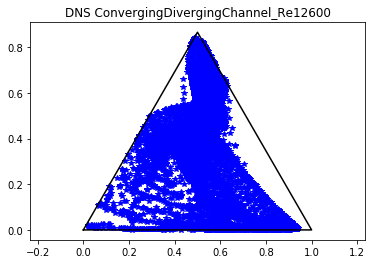

In [3]:
case = "ConvergingDivergingChannel"

plt.figure()
plt.title('DNS %s_Re%i' % (case, Re_test[0]))
plt.plot(baryMap_DNS[0,:,:],baryMap_DNS[1,:,:],'b*')
plt.plot([0,1,0.5,0],[0,0,np.sin(60*(np.pi/180)),0],'k-')
plt.axis('equal')
plt.show()

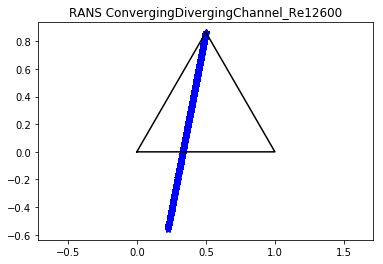

In [4]:
plt.figure()
plt.title("RANS %s_Re%i" % (case, Re_test[0]))
plt.plot(baryMap_RANS[0,:,:],baryMap_RANS[1,:,:],'b*')
plt.plot([0,1,0.5,0],[0,0,np.sin(60*(np.pi/180)),0],'k-')
plt.axis('equal')
plt.show()


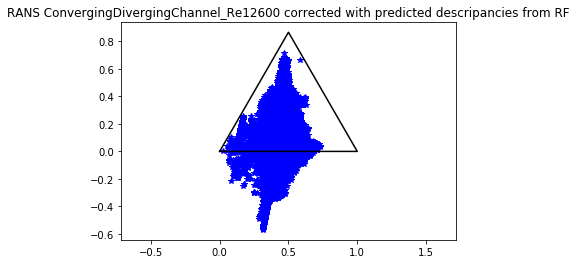

In [5]:
plt.figure()
plt.title("RANS %s_Re%i corrected with predicted descripancies from RF" % (case, Re_test[0]))
plt.plot(np.add(test_discr[0,:,:], baryMap_RANS[0,:,:]) ,np.add(test_discr[1,:,:],baryMap_RANS[1,:,:]),'b*')
plt.plot([0,1,0.5,0],[0,0,np.sin(60*(np.pi/180)),0],'k-')
plt.axis('equal')
plt.show()

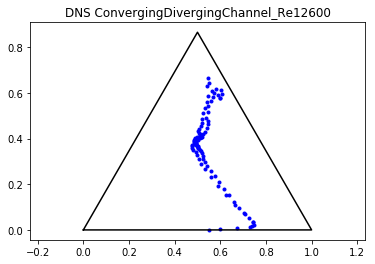

In [25]:
plt.figure()
plt.title('DNS %s_Re%i' % (case, Re_test[0]))
plt.plot(baryMap_DNS[0,5,:],baryMap_DNS[1,5,:],'b.')
plt.plot([0,1,0.5,0],[0,0,np.sin(60*(np.pi/180)),0],'k-')
plt.axis('equal')
plt.show()

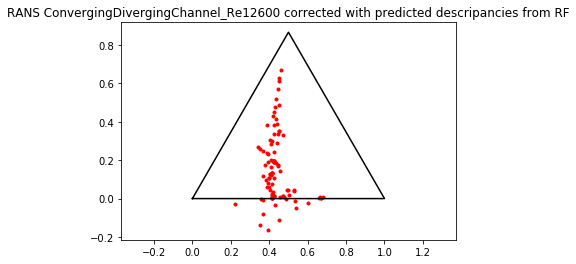

In [26]:
plt.figure()
plt.title("RANS %s_Re%i corrected with predicted descripancies from RF" % (case, Re_test[0]))
plt.plot(np.add(test_discr[0,5,:], baryMap_RANS[0,5,:]) ,np.add(test_discr[1,5,:],baryMap_RANS[1,5,:]),'r.')
plt.plot([0,1,0.5,0],[0,0,np.sin(60*(np.pi/180)),0],'k-')
plt.axis('equal')
plt.show()


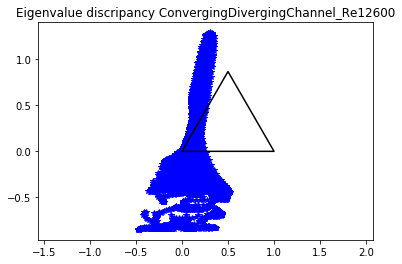

In [9]:

plt.figure()
plt.title("Eigenvalue discripancy %s_Re%i" % (case, Re_test[0]))
plt.plot(baryMap_discr[0,:,:],baryMap_discr[1,:,:],'b*')
plt.plot([0,1,0.5,0],[0,0,np.sin(60*(np.pi/180)),0],'k-')
plt.axis('equal')
plt.show()

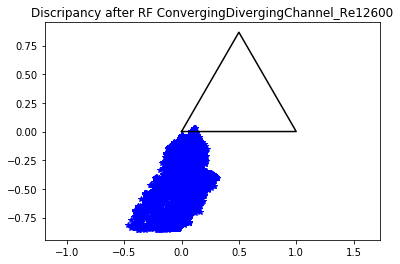

In [10]:
plt.figure()
plt.title("Discripancy after RF %s_Re%i" % (case, Re_test[0]))
plt.plot(test_discr[0,:,:],test_discr[1,:,:],'b*')
plt.plot([0,1,0.5,0],[0,0,np.sin(60*(np.pi/180)),0],'k-')
plt.axis('equal')
plt.show()

In [14]:
meshRANS, U_RANS, gradU_RANS, p_RANS, gradp_RANS, tau_RANS, k_RANS, gradk_RANS, yWall_RANS, omega_RANS, S_RANS, Omega_RANS = RANS("ConvergingDivergingChannel", Re_test[0], 'kOmega', 7000, 140, 100)

plt.figure()
plt.title("Velocity from DNS")
plt.contourf(meshRANS[0,:,:], meshRANS[1,:,:], dataDNS_i['um'],20)
plt.show()

plt.figure()
plt.title("Velocity from RANS")
plt.contourf(meshRANS[0,:,:], meshRANS[1,:,:], U_RANS[0,:,:],20)
plt.show()

NameError: name 'dataDNS_i' is not defined

In [15]:
plt.figure()
plt.title("k from DNS")
plt.contourf(meshRANS[0,:,:], meshRANS[1,:,:], dataDNS_i['k'],20)
plt.show()
 
plt.figure()
plt.title("k from RANS") 
plt.contourf(meshRANS[0,:,:], meshRANS[1,:,:], dataRANS_k,20)
plt.show()

NameError: name 'dataDNS_i' is not defined

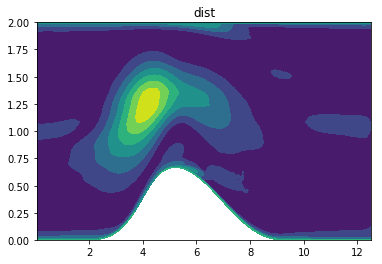

In [17]:
plt.figure()
plt.title("dist")
plt.contourf(meshRANS[0,:,:], meshRANS[1,:,:], foam.baryMap_dist(baryMap_RANS,baryMap_DNS))
plt.show()

In [18]:
import numpy as np
import matplotlib.pyplot as plt

In [19]:
def f(x):
    return ((((((x * x) / ((((x * x) * (x * x)) - ((x * x) - ((x * x) * (x * x)))) - ((((x * x) * (x * x)) - ((x * x) - ((x * x) * (x * x)))) / (((x * x) * (x * x)) - ((x * x) - ((x * x) * (x * x))))))) * ((((((x * x) - ((x * x) * (x * x))) * ((x * x) * (x * x))) * ((((x * x) * (x * x)) - ((x * x) - ((x * x) * (x * x)))) / (((x * x) * (x * x)) - ((x * x) - ((x * x) * (x * x)))))) + ((((x * x) * (x * x)) - ((x * x) - ((x * x) * (x * x)))) - ((((x * x) * (x * x)) - ((x * x) - ((x * x) * (x * x)))) / (((x * x) * (x * x)) - ((x * x) - ((x * x) * (x * x))))))) * (x / ((x * x) * (x * x))))) / ((((x * x) * (x * x)) - ((x * x) - ((x * x) * (x * x)))) / (((x * x) * (x * x)) - ((x * x) - ((x * x) * (x * x)))))) * ((((((((x * x) * (x * x)) - ((x * x) - ((x * x) * (x * x)))) / (((x * x) * (x * x)) - ((x * x) - ((x * x) * (x * x))))) - ((x * x) * (x * x))) + (((((x * x) * (x * x)) - ((x * x) - ((x * x) * (x * x)))) * (((((x * x) - ((x * x) * (x * x))) * ((x * x) * (x * x))) * ((((x * x) * (x * x)) - ((x * x) - ((x * x) * (x * x)))) / (((x * x) * (x * x)) - ((x * x) - ((x * x) * (x * x)))))) * (((x * x) / ((((x * x) * (x * x)) - ((x * x) - ((x * x) * (x * x)))) - ((((x * x) * (x * x)) - ((x * x) - ((x * x) * (x * x)))) / (((x * x) * (x * x)) - ((x * x) - ((x * x) * (x * x))))))) / x))) * (((((x * x) - ((x * x) * (x * x))) * ((x * x) * (x * x))) * ((((x * x) * (x * x)) - ((x * x) - ((x * x) * (x * x)))) / (((x * x) * (x * x)) - ((x * x) - ((x * x) * (x * x)))))) * (((x * x) / ((((x * x) * (x * x)) - ((x * x) - ((x * x) * (x * x)))) - ((((x * x) * (x * x)) - ((x * x) - ((x * x) * (x * x)))) / (((x * x) * (x * x)) - ((x * x) - ((x * x) * (x * x))))))) / x)))) * (((((x * x) - ((x * x) * (x * x))) * ((x * x) * (x * x))) * ((((x * x) * (x * x)) - ((x * x) - ((x * x) * (x * x)))) / (((x * x) * (x * x)) - ((x * x) - ((x * x) * (x * x)))))) * (((((x * x) - ((x * x) * (x * x))) * ((x * x) * (x * x))) * ((((x * x) * (x * x)) - ((x * x) - ((x * x) * (x * x)))) / (((x * x) * (x * x)) - ((x * x) - ((x * x) * (x * x)))))) + ((((x * x) * (x * x)) - ((x * x) - ((x * x) * (x * x)))) - ((((x * x) * (x * x)) - ((x * x) - ((x * x) * (x * x)))) / (((x * x) * (x * x)) - ((x * x) - ((x * x) * (x * x))))))))) + ((x * x) + (((((x * x) * (x * x)) - ((x * x) - ((x * x) * (x * x)))) * (((((x * x) - ((x * x) * (x * x))) * ((x * x) * (x * x))) * ((((x * x) * (x * x)) - ((x * x) - ((x * x) * (x * x)))) / (((x * x) * (x * x)) - ((x * x) - ((x * x) * (x * x)))))) * (((x * x) / ((((x * x) * (x * x)) - ((x * x) - ((x * x) * (x * x)))) - ((((x * x) * (x * x)) - ((x * x) - ((x * x) * (x * x)))) / (((x * x) * (x * x)) - ((x * x) - ((x * x) * (x * x))))))) / x))) * (((((x * x) - ((x * x) * (x * x))) * ((x * x) * (x * x))) * ((((x * x) * (x * x)) - ((x * x) - ((x * x) * (x * x)))) / (((x * x) * (x * x)) - ((x * x) - ((x * x) * (x * x)))))) * (((x * x) / ((((x * x) * (x * x)) - ((x * x) - ((x * x) * (x * x)))) - ((((x * x) * (x * x)) - ((x * x) - ((x * x) * (x * x)))) / (((x * x) * (x * x)) - ((x * x) - ((x * x) * (x * x))))))) / x)))))) - (((((((x * x) * (x * x)) - ((x * x) - ((x * x) * (x * x)))) * (((((x * x) - ((x * x) * (x * x))) * ((x * x) * (x * x))) * ((((x * x) * (x * x)) - ((x * x) - ((x * x) * (x * x)))) / (((x * x) * (x * x)) - ((x * x) - ((x * x) * (x * x)))))) * (((x * x) / ((((x * x) * (x * x)) - ((x * x) - ((x * x) * (x * x)))) - ((((x * x) * (x * x)) - ((x * x) - ((x * x) * (x * x)))) / (((x * x) * (x * x)) - ((x * x) - ((x * x) * (x * x))))))) / x))) * (((((x * x) - ((x * x) * (x * x))) * ((x * x) * (x * x))) * ((((x * x) * (x * x)) - ((x * x) - ((x * x) * (x * x)))) / (((x * x) * (x * x)) - ((x * x) - ((x * x) * (x * x)))))) * (((x * x) / ((((x * x) * (x * x)) - ((x * x) - ((x * x) * (x * x)))) - ((((x * x) * (x * x)) - ((x * x) - ((x * x) * (x * x)))) / (((x * x) * (x * x)) - ((x * x) - ((x * x) * (x * x))))))) / x))) * ((((x * x) * (x * x)) - ((x * x) - ((x * x) * (x * x)))) + ((((x * x) * (x * x)) - ((x * x) - ((x * x) * (x * x)))) - ((((x * x) * (x * x)) - ((x * x) - ((x * x) * (x * x)))) / (((x * x) * (x * x)) - ((x * x) - ((x * x) * (x * x)))))))) * (((((x * x) - ((x * x) * (x * x))) * ((x * x) * (x * x))) * ((((x * x) * (x * x)) - ((x * x) - ((x * x) * (x * x)))) / (((x * x) * (x * x)) - ((x * x) - ((x * x) * (x * x)))))) * (((x * x) / ((((x * x) * (x * x)) - ((x * x) - ((x * x) * (x * x)))) - ((((x * x) * (x * x)) - ((x * x) - ((x * x) * (x * x)))) / (((x * x) * (x * x)) - ((x * x) - ((x * x) * (x * x))))))) / x))))

In [20]:
x = np.linspace(-5, 5, 100)

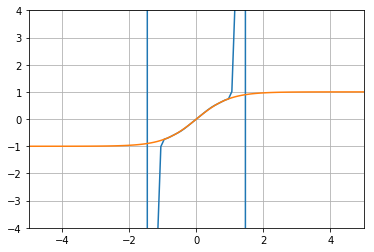

In [21]:
plt.figure()
plt.plot(x, f(x))
plt.plot(x, np.tanh(x))
plt.grid()
plt.xlim((-5, 5))
plt.ylim((-4, 4))
plt.show()